In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    return train_dl, test_dl, valid_dl



In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner1 = nn.Linear(28*28, 200)
        self.liner2 = nn.Linear(200,28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        z = self.liner1(x) #Encorder
        z = self.relu(z)
        y = self.liner2(z) #Decorder
        y = self.sigmoid(y)
        return y


In [8]:
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = 0
    iter_num = 0

    for datas, _ in dl:
        datas = datas.to(device)
        iter_num += 1

        if optimizer:
            logits = model(datas)
            loss = criterion(logits, datas.view(-1, 28*28))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(datas)
                loss = criterion(logits, datas.view(-1, 28*28))
            
        losses += loss.item()

    return losses/iter_num
        

EPOCH:0, Train: loss=0.221, Valid: loss=0.141
EPOCH:5, Train: loss=0.0777, Valid: loss=0.0769
EPOCH:10, Train: loss=0.0699, Valid: loss=0.0703
EPOCH:15, Train: loss=0.0678, Valid: loss=0.0683
EPOCH:20, Train: loss=0.0668, Valid: loss=0.0674
EPOCH:25, Train: loss=0.0662, Valid: loss=0.0668
Best train loss=0.0658 Best valid loss=0.0665 Test loss=0.0656


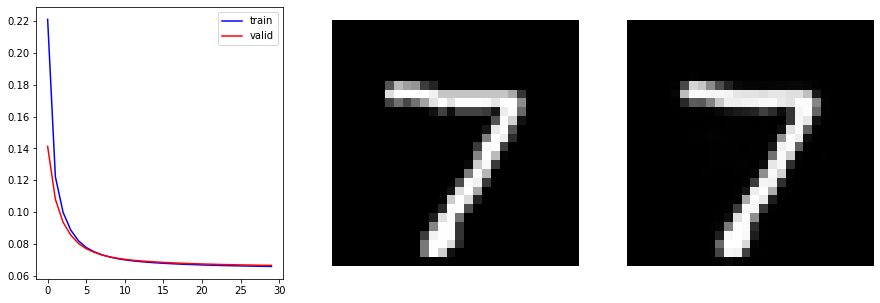

In [14]:
#AutoEncorder

# Constants
EPOCH_NUM = 30
TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, valid_dl = create_dataloader('MNIST', transform, valid=True)

model = AutoEncoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)

train_loss_list, valid_loss_list = [], []
best_train_loss, best_valid_loss = None,None

testdata, _ = next(iter(test_dl))
testdata = testdata[0].to(device)

for epoch in range(EPOCH_NUM):
    train_loss = one_epoch(model, train_dl, device, criterion, optimizer)
    train_loss_list.append(train_loss)

    if epoch==0 or best_train_loss >= train_loss:
        best_train_loss = train_loss
    
    valid_loss = one_epoch(model, valid_dl, device, criterion)
    valid_loss_list.append(valid_loss)

    if epoch==0 or best_valid_loss >= valid_loss:
        best_valid_loss = valid_loss

        test_loss = one_epoch(model, test_dl, device, criterion)
        model.eval()
        with torch.no_grad():
            rec_data = model(testdata)
    if epoch%5 == 0:
        print('EPOCH:{:}, Train: loss={:.3}, Valid: loss={:.3}'.format(epoch, train_loss, valid_loss))
        
print('Best train loss={:.3} Best valid loss={:.3} Test loss={:.3}'.format(best_train_loss, best_valid_loss, test_loss))

fig = plt.figure(figsize=(15.0, 5.0))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(valid_loss_list, 'r', label='valid')
ax1.legend()

ax2 = fig.add_subplot(1,3,2)
testdata = testdata.view(28,28).detach().cpu().numpy()
ax2.imshow(testdata, cmap='binary_r')
ax2.axis('off')

ax3 = fig.add_subplot(1,3,3)
rec_data = rec_data.view(28,28).detach().cpu().numpy()
ax3.imshow(rec_data, cmap='binary_r')
ax3.axis('off')

plt.show()